In [1]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
#import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
data_path = "C:/Users/maffd/Desktop/CS412/dataset/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:
            
        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )
                
        code2convos[file_code] = convo_texts

100%|██████████| 127/127 [00:11<00:00, 11.11it/s]


In [3]:
# let's see one of the conversations
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"][0])

{'role': 'user',
 'text': 'Load a CSV file into a Pandas in Python. The file is named '
         "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
         "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
         "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
         "'Health Metrics'. \n"}


#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [4]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts    

In [5]:
# Get the answers
answers = []
code2answers = defaultdict(list)
for code , convos in code2convos.items():
    user_answers = []
    for conv in convos:
        if conv["role"] == "assistant":
            answers.append(conv["text"])
            user_answers.append(conv["text"])
    code2answers[code] = user_answers

In [6]:
prompts[0]

"Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'. \n"

In [7]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

BURADA PREPROCESSING YAPALIM ÖDEVDEKİ GİBİ (STOP WORD ÇIKARMA ROOT ALMA VS VS)

In [8]:
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(prompts + questions)

In [9]:
# Bag of Words Approach

from sklearn.feature_extraction.text import CountVectorizer
vectorizer_BoW = CountVectorizer()
vectorizer_BoW = vectorizer_BoW.fit(prompts + questions)            # Choose to add GPT responses or not

In [10]:
# Word2Vec Approach

from gensim.models import Word2Vec
questions_and_prompts_and_answers = [sentence.split() for sentence in prompts + questions]      # Choose to add GPT responses or not

vector_size = 500               # These can be tuned
window = 5
min_count = 5

w2v_model = Word2Vec(
    questions_and_prompts_and_answers,
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    workers=4)


def vectorize(q_and_p_and_a, model):
    word_vectors = [model.wv[word] for word in q_and_p_and_a if word in model.wv]

    if not word_vectors:
        return np.zeros(model.vector_size)  # Return zero vector if no word vectors are found

    avg_vector = np.mean(word_vectors, axis=0)
    return avg_vector

In [11]:
questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
questions_TF_IDF.head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Bag of Words Approach

questions_BoW = pd.DataFrame(vectorizer_BoW.transform(questions).toarray(), columns=vectorizer_BoW.get_feature_names_out())
questions_BoW.head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Word2Vec Approach

questions_w2v = pd.DataFrame([vectorize(sentence, w2v_model) for sentence in questions], columns=[f'w2v_{i}' for i in range(vector_size)])
questions_w2v.head()

,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,w2v_9,...,w2v_490,w2v_491,w2v_492,w2v_493,w2v_494,w2v_495,w2v_496,w2v_497,w2v_498,w2v_499
0,0.186528,0.184444,0.253452,0.255932,-0.009873,-0.240552,-0.191556,0.294687,0.009712,0.110174,...,0.129385,-0.142694,0.176317,0.092631,-0.021492,-0.196113,0.007852,-0.012902,-0.130394,-0.211506
1,0.186735,0.205699,0.312503,0.291411,0.024465,-0.281729,-0.184981,0.342090,-0.001017,0.147730,...,0.134739,-0.223664,0.199785,0.113692,-0.031015,-0.224065,0.013648,-0.012471,-0.163400,-0.260177
2,0.200286,0.179435,0.296148,0.270218,0.018153,-0.223015,-0.123293,0.261372,0.042361,0.124138,...,0.125953,-0.180571,0.197669,0.061700,-0.013600,-0.148512,0.051013,-0.051112,-0.160147,-0.210163
3,0.224008,0.192290,0.280209,0.244660,0.003772,-0.242429,-0.128185,0.287660,0.030071,0.101249,...,0.127644,-0.146132,0.205014,0.010835,0.037539,-0.172590,0.026573,-0.058952,-0.131911,-0.205890
4,0.179250,0.196242,0.256542,0.244766,0.000580,-0.247880,-0.183457,0.315281,0.002573,0.117292,...,0.128855,-0.152315,0.171778,0.091597,-0.017231,-0.205278,0.002169,-0.029964,-0.136994,-0.213222


In [14]:
code2prompts_tf_idf = dict()
for code, user_prompts in code2prompts.items():
    # code = "0031c86e-81f4-4eef-9e0e-28037abf9883", user_prompts = [prompt1, prompt2, ...]
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2prompts_tf_idf[code] = prompts_TF_IDF

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [15]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape

(86, 5400)

In [17]:
# Bag of Words Approach

code2prompts_BoW = dict()
for code, user_prompts in code2prompts.items():
    # code = "0031c86e-81f4-4eef-9e0e-28037abf9883", user_prompts = [prompt1, prompt2, ...]
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_BoW = pd.DataFrame(vectorizer_BoW.transform(user_prompts).toarray(), columns=vectorizer_BoW.get_feature_names_out())
    code2prompts_BoW[code] = prompts_BoW

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [18]:
# Word2Vec Approach

code2prompts_w2v = dict()

for code, user_prompts in code2prompts.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue

    prompts_Word2Vec = pd.DataFrame([vectorize(sentence.split(), w2v_model) for sentence in user_prompts], columns=[f'w2v_{i}' for i in range(vector_size)])
    code2prompts_w2v[code] = prompts_Word2Vec

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [19]:
code2cosine = dict()
for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))

In [20]:
questions[4]

"Features and Correlations (10 pts)\n\n* Correlations of features with health (4 points)\nCalculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.\n\n* Feature Selection (3 points)\nSelect a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.\n\n* Hypothetical Driver Features (3 points)\nPropose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.\n\n* __Note:__ You get can get help from GPT.\n"

In [21]:
code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()


question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.153541,0.294879,0.522169,0.352243,0.460606,0.553876,0.167250,0.182938,0.195440
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.192013,0.795607,0.772184,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866
2,041f950b-c013-409a-a642-cffff60b9d4b,0.258306,0.295923,0.624824,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.145965,0.117841,0.267346,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.344182,0.575528,0.782883,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769
...,...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.187393,0.209889,0.358875,0.211246,0.149281,0.507128,1.000000,0.862585,0.739634
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.144760,0.139495,0.332267,0.950344,0.775698,0.828355,0.374145,0.905688,0.553341
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.211008,0.908697,0.977725,0.924311,0.888609,0.921306,0.779558,0.767328,0.499508
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.173215,0.967321,1.000000,0.703987,0.942662,0.907417,1.000000,1.000000,0.782938


Applying PCA to Each of the Vectorizers and Examining the Explained Variance

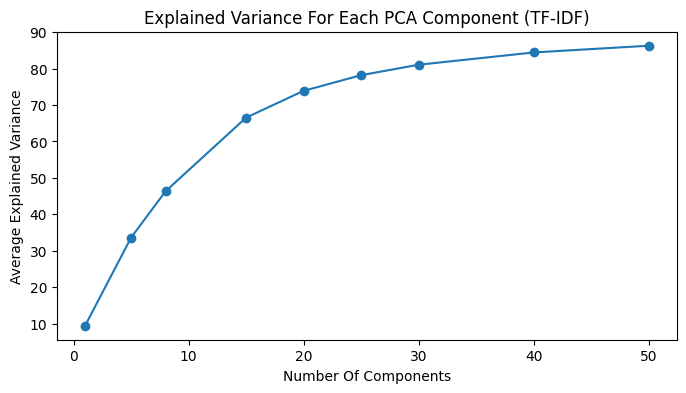

In [22]:
# Use PCA to TF-IDF vectorized prompts

from sklearn.decomposition import PCA
components = [1,5,8,15,20,25,30,40,50]
avg_exp_variances = []


for n in components:
    
    exp_variances = []
    for code, user_prompts_TF_IDF in code2prompts_tf_idf.items():
        pca = PCA(n_components = min(n, len(user_prompts_TF_IDF)), random_state=43)
        pca_df = pca.fit_transform(pd.concat([user_prompts_TF_IDF, questions_TF_IDF]))
        exp_variances.append(pca.explained_variance_ratio_.sum() * 100)

    avg_exp_variance = np.mean(exp_variances)
    avg_exp_variances.append(avg_exp_variance)
        
plt.figure(figsize=(8,4))
plt.plot(components, avg_exp_variances, marker='o')
plt.title('Explained Variance For Each PCA Component (TF-IDF)'.format(n))
plt.xlabel('Number Of Components')
plt.ylabel('Average Explained Variance')
plt.show()

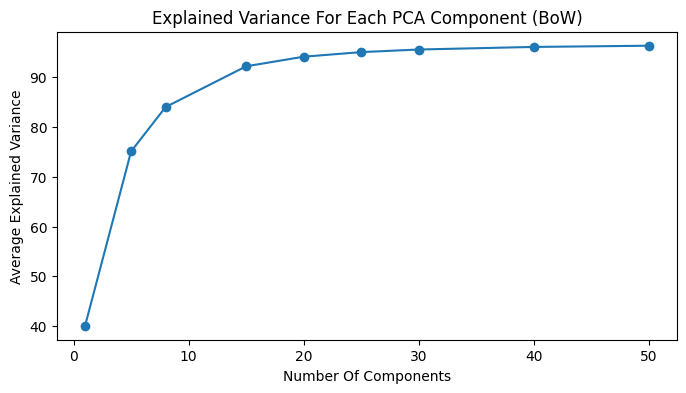

In [23]:
# Use PCA to BoW vectorized prompts

from sklearn.decomposition import PCA
components = [1,5,8,15,20,25,30,40,50]
avg_exp_variances = []


for n in components:
    exp_variances = []
    for code, user_prompts_BoW in code2prompts_BoW.items():
        pca = PCA(n_components = min(n, len(user_prompts_BoW)), random_state=43)
        pca_df = pca.fit_transform(pd.concat([user_prompts_BoW, questions_BoW]))
        exp_variances.append(pca.explained_variance_ratio_.sum() * 100)

    avg_exp_variance = np.mean(exp_variances)
    avg_exp_variances.append(avg_exp_variance)
        
plt.figure(figsize=(8,4))
plt.plot(components, avg_exp_variances, marker='o')
plt.title('Explained Variance For Each PCA Component (BoW)'.format(n))
plt.xlabel('Number Of Components')
plt.ylabel('Average Explained Variance')
plt.show()

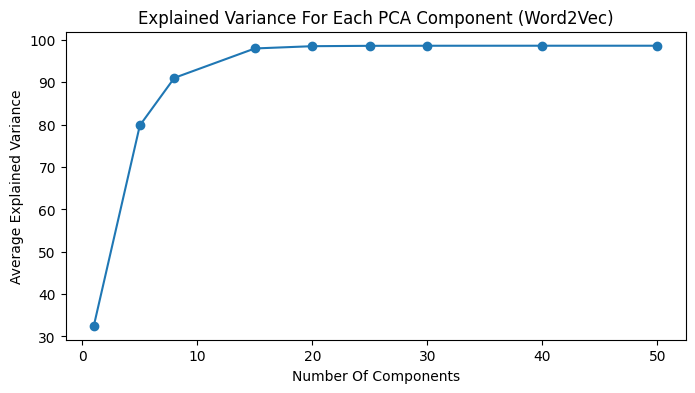

In [24]:
# Use PCA to word2vec vectorized prompts

from sklearn.decomposition import PCA
components = [1,5,8,15,20,25,30,40,50]
avg_exp_variances = []


for n in components:
    
    exp_variances = []
    for code, user_prompts_w2v in code2prompts_w2v.items():
        pca = PCA(n_components = min(n, len(user_prompts_w2v)), random_state=43)
        pca_df = pca.fit_transform(pd.concat([user_prompts_w2v, questions_w2v]))
        exp_variances.append(pca.explained_variance_ratio_.sum() * 100)

    avg_exp_variance = np.mean(exp_variances)
    avg_exp_variances.append(avg_exp_variance)
        
plt.figure(figsize=(8,4))
plt.plot(components, avg_exp_variances, marker='o')
plt.title('Explained Variance For Each PCA Component (Word2Vec)'.format(n))
plt.xlabel('Number Of Components')
plt.ylabel('Average Explained Variance')
plt.show()

In [25]:
# Transform a TF-IDF vectorizer to the prompts and answers
# prompts_answers_combined = [p + ' ' + a for p, a in zip(prompts, answers)]

# vectorizer = TfidfVectorizer()
# vectorizer = vectorizer.fit(prompts_answers_combined + questions)

# questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
# prompts_answers_TF_IDF = pd.DataFrame(vectorizer.transform(prompts_answers_combined).toarray(), columns=vectorizer.get_feature_names_out())
# prompts_TF_IDF = pd.DataFrame(vectorizer.transform(prompts).toarray(), columns=vectorizer.get_feature_names_out())
# prompts_TF_IDF.head()

In [26]:
# Scale the columns of the vectorized data
# from sklearn.discriminant_analysis import StandardScaler
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# scaled_prompts_answers_TF_IDF = pd.DataFrame(scaler.fit_transform(prompts_answers_TF_IDF))
# scaled_prompts_TF_IDF = pd.DataFrame(scaler.fit_transform(prompts_TF_IDF))
# scaled_questions_TF_IDF = pd.DataFrame(scaler.fit_transform(questions_TF_IDF))

In [27]:
# Use K-means clustering with TF-IDF vectorized prompts
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scores = []
for code, user_prompts_TF_IDF in code2prompts_tf_idf.items():
    # Combine user prompts BoW and questions BoW
    combined_data = pd.concat([user_prompts_TF_IDF, questions_TF_IDF])

    # Determine the number of components dynamically
    n_components = min(35, min(combined_data.shape))

    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_df = pca.fit_transform(combined_data)

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=9, random_state=0, n_init=25).fit(pca_df)

    # Get the silhouette score
    silhouette = silhouette_score(pca_df, kmeans.labels_)
    scores.append(silhouette)

average_score = np.mean(scores)
print(f"Average Silhouette Score: {average_score}")

Average Silhouette Score: 0.13915191458165754


In [28]:
# Use K-means clustering with BoW vectorized prompts

scores = []

for code, user_prompts_BoW in code2prompts_BoW.items():
    # Combine user prompts BoW and questions BoW
    combined_data = pd.concat([user_prompts_BoW, questions_BoW])

    # Determine the number of components dynamically
    n_components = min(17, min(combined_data.shape))

    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_df = pca.fit_transform(combined_data)

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=9, random_state=0, n_init=25).fit(pca_df)

    # Get the silhouette score
    silhouette = silhouette_score(pca_df, kmeans.labels_)
    scores.append(silhouette)

average_score = np.mean(scores)
print(f"Silhouette Score: {average_score}")

Silhouette Score: 0.34255657562980923


In [29]:
# Use K-means clustering with word2vec vectorized prompts

scores = []

userSalihGogaBoga = 0

for code, user_prompts_w2v in code2prompts_w2v.items():
    # Combine user prompts BoW and questions BoW
    combined_data = pd.concat([user_prompts_w2v, questions_w2v])

    userSalihGogaBoga = user_prompts_w2v

    # Determine the number of components dynamically
    n_components = min(10, min(combined_data.shape))

    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_df = pca.fit_transform(combined_data)

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=9, random_state=0, n_init=25).fit(pca_df)

    # Get the silhouette score
    silhouette = silhouette_score(pca_df, kmeans.labels_)
    scores.append(silhouette)

average_score = np.mean(scores)
print(userSalihGogaBoga)
print(f"Silhouette Score: {average_score}")

       w2v_0     w2v_1     w2v_2     w2v_3     w2v_4     w2v_5     w2v_6  \
0   0.181244  0.107329  0.366138  0.246962 -0.204230 -0.277685 -0.046623   
1   0.139681  0.120432  0.238742  0.375091 -0.191969 -0.265567 -0.209327   
2   0.080614  0.086558  0.160193  0.134370 -0.049788 -0.171353 -0.045481   
3   0.118233 -0.024273  0.264889  0.385912 -0.259404 -0.237919 -0.137576   
4   0.258534  0.074691  0.489247  0.573497 -0.232057 -0.282251 -0.202758   
5   0.248987  0.221243  0.312886  0.348530 -0.050197 -0.208940 -0.093359   
6   0.133444 -0.036814  0.203219  0.346733 -0.280864 -0.295371 -0.155518   
7   0.008784  0.111810  0.187278  0.298496 -0.151710 -0.245955 -0.255798   
8   0.100190  0.100362  0.285323  0.237141 -0.074390 -0.263751 -0.146126   
9   0.192652  0.179508  0.194061  0.191080 -0.085523 -0.297685 -0.191777   
10  0.269846  0.113886  0.488682  0.418166 -0.212051 -0.466497 -0.101709   
11  0.152252  0.159153  0.220682  0.074557 -0.042548 -0.216208 -0.044431   
12  0.111496

Cluster 0: 8 data points
Cluster 1: 4 data points
Cluster 2: 15 data points
Cluster 3: 4 data points
Cluster 4: 1 data points
Cluster 5: 4 data points
Cluster 6: 1 data points
Cluster 7: 2 data points
Cluster 8: 1 data points
40


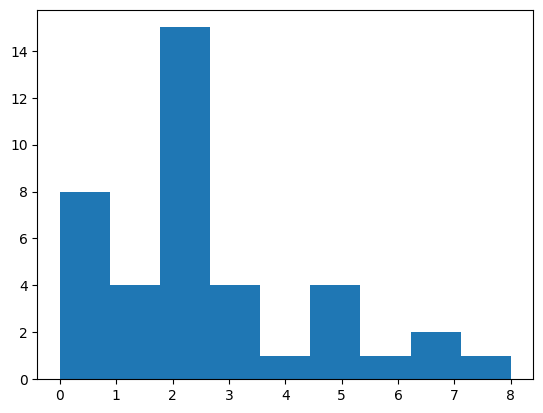

In [30]:
plt.hist(kmeans.labels_, bins=9)

label_counts = np.bincount(kmeans.labels_)

total = 0

# Print the counts
for cluster_label, count in enumerate(label_counts):
    total += count
    print(f'Cluster {cluster_label}: {count} data points')

print(total)

In [ ]:
# Apply agglomerative clustering on the prompts_TF_IDF
from sklearn.cluster import AgglomerativeClustering

agg_data = prompts_TF_IDF                    # Use only prompts this time, compare with questions at the end
agg = AgglomerativeClustering(metric="cosine", n_clusters=9, linkage='average').fit(agg_data)

# Get the silhouette score
silhouette = silhouette_score(agg_data, agg.labels_)
print(f"Silhouette Score: {silhouette}")

We definitely have overlapping clusters. Gaussian Mixture Model may provide better solutions...

# Feature Engineering
- Number of prompts that a uers asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [ ]:
code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["error", "no", "thank", "next", "Entropy"]       # Koyulacak bir şeyler var mı buraya
keywords2search = [k.lower() for k in keywords2search]

for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features[code]["#user_prompts"] += 1
            
            # count the keywords
            for kw in keywords2search:
                code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            code2features[code]["prompt_avg_chars"] += len(text)
        else:
            # ChatGPT Responses
            code2features[code]["response_avg_chars"] += len(text)

        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]   
        code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]

In [ ]:
df = pd.DataFrame(code2features).T
df.head(5)

In [ ]:
# reading the scores
scores = pd.read_csv("data/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

In [ ]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

In [ ]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

In [ ]:
df = pd.merge(df, question_mapping_scores, on="code", how="left")
df.head()

#### Merging scores with features

In [ ]:
temp_df = pd.merge(df, scores, on='code', how="left")
temp_df.dropna(inplace=True)
temp_df.drop_duplicates("code",inplace=True, keep="first")
temp_df.head()

In [ ]:
X = temp_df[temp_df.columns[1:-1]].to_numpy()
y = temp_df["grade"].to_numpy()
print(X.shape, y.shape)

#### Train/Test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

#### Fitting a model

#### Predicting and Analyzing 

In [ ]:
regressor = DecisionTreeRegressor(random_state=0,criterion='squared_error', max_depth=10)
regressor.fit(X_train, y_train)

In [ ]:
extracted_MSEs = regressor.tree_.impurity   
for idx, MSE in enumerate(regressor.tree_.impurity):
    print("Node {} has MSE {}".format(idx,MSE))

In [ ]:
# Plotting the Tree 
dot_data = tree.export_graphviz(regressor, out_file=None, feature_names=temp_df.columns[1:-1])
graph = graphviz.Source(dot_data)
graph.render("hw")

In [ ]:
# Prediction
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))
